# Задание 2.2 - Введение в PyTorch

Для этого задания потребуется установить версию PyTorch 1.0

https://pytorch.org/get-started/locally/

В этом задании мы познакомимся с основными компонентами PyTorch и натренируем несколько небольших моделей.<br>
GPU нам пока не понадобится.

Основные ссылки:  
https://pytorch.org/tutorials/beginner/deep_learning_60min_blitz.html  
https://pytorch.org/docs/stable/nn.html  
https://pytorch.org/docs/stable/torchvision/index.html  

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.datasets as dset
from torch.utils.data.sampler import SubsetRandomSampler, Sampler

from torchvision import transforms

import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np

## Как всегда, начинаем с загрузки данных

PyTorch поддерживает загрузку SVHN из коробки.

In [2]:
# First, lets load the dataset
data_train = dset.SVHN('./data/', split='train',
                       transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize(mean=[0.43,0.44,0.47],
                                               std=[0.20,0.20,0.20])                           
                       ])
                      )
data_test = dset.SVHN('./data/', split='test', 
                      transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize(mean=[0.43,0.44,0.47],
                                               std=[0.20,0.20,0.20])                           
                       ]))

Теперь мы разделим данные на training и validation с использованием классов `SubsetRandomSampler` и `DataLoader`.

`DataLoader` подгружает данные, предоставляемые классом `Dataset`, во время тренировки и группирует их в батчи.
Он дает возможность указать `Sampler`, который выбирает, какие примеры из датасета использовать для тренировки. Мы используем это, чтобы разделить данные на training и validation.

Подробнее: https://pytorch.org/tutorials/beginner/data_loading_tutorial.html

In [3]:
batch_size = 64

data_size = data_train.data.shape[0]
validation_split = .2
split = int(np.floor(validation_split * data_size))
indices = list(range(data_size))
np.random.shuffle(indices)

train_indices, val_indices = indices[split:], indices[:split]

train_sampler = SubsetRandomSampler(train_indices)
val_sampler = SubsetRandomSampler(val_indices)

train_loader = torch.utils.data.DataLoader(data_train, batch_size=batch_size, 
                                           sampler=train_sampler)
val_loader = torch.utils.data.DataLoader(data_train, batch_size=batch_size,
                                         sampler=val_sampler)

В нашей задаче мы получаем на вход изображения, но работаем с ними как с одномерными массивами. Чтобы превратить многомерный массив в одномерный, мы воспользуемся очень простым вспомогательным модулем `Flattener`.

In [4]:
sample, label = data_train[0]
print("SVHN data sample shape: ", sample.shape)
# As you can see, the data is shaped like an image

# We'll use a special helper module to shape it into a tensor
class Flattener(nn.Module):
    def forward(self, x):
        batch_size, *_ = x.shape
        return x.view(batch_size, -1)

SVHN data sample shape:  torch.Size([3, 32, 32])


И наконец, мы создаем основные объекты PyTorch:
- `nn_model` - собственно, модель с нейросетью
- `loss` - функцию ошибки, в нашем случае `CrossEntropyLoss`
- `optimizer` - алгоритм оптимизации, в нашем случае просто `SGD`

In [5]:
nn_model = nn.Sequential(
            Flattener(),
            nn.Linear(3*32*32, 100),
            nn.ReLU(inplace=True),
            nn.Linear(100, 10), 
         )
nn_model.type(torch.FloatTensor)

# We will minimize cross-entropy between the ground truth and
# network predictions using an SGD optimizer
loss = nn.CrossEntropyLoss().type(torch.FloatTensor)
optimizer = optim.SGD(nn_model.parameters(), lr=1e-2, weight_decay=1e-1)

## Тренируем!

Ниже приведена функция `train_model`, реализующая основной цикл тренировки PyTorch.

Каждую эпоху эта функция вызывает функцию `compute_accuracy`, которая вычисляет точность на validation, эту последнюю функцию предлагается реализовать вам.

In [6]:
# This is how to implement the same main train loop in PyTorch. Pretty easy, right?

def train_model(model, train_loader, val_loader, loss, optimizer, num_epochs):    
    loss_history = []
    train_history = []
    val_history = []
    for epoch in range(num_epochs):
        model.train() # Enter train mode
        
        loss_accum = 0
        correct_samples = 0
        total_samples = 0
        for i_step, (x, y) in enumerate(train_loader):
            prediction = model(x)    
            loss_value = loss(prediction, y)
            optimizer.zero_grad()
            loss_value.backward()
            optimizer.step()
            
            _, indices = torch.max(prediction, 1)
            correct_samples += torch.sum(indices == y)
            total_samples += y.shape[0]
            
            loss_accum += loss_value

        ave_loss = loss_accum / (i_step + 1)
        train_accuracy = float(correct_samples) / total_samples
        val_accuracy = compute_accuracy(model, val_loader)
        
        loss_history.append(float(ave_loss))
        train_history.append(train_accuracy)
        val_history.append(val_accuracy)
        
        print("Average loss: %f, Train accuracy: %f, Val accuracy: %f" % (ave_loss, train_accuracy, val_accuracy))
        
    return loss_history, train_history, val_history
        
def compute_accuracy(model, loader):
    """
    Computes accuracy on the dataset wrapped in a loader
    
    Returns: accuracy as a float value between 0 and 1
    """
    correct_samples = 0
    total_samples = 0
    
    model.eval()
    for i_step, (x, y) in enumerate(loader):
        pred = model(x)
        _, indices = torch.max(pred, 1)
        correct_samples += torch.sum(indices == y)
        total_samples += y.shape[0]
    
    return float(correct_samples) / total_samples

loss_history, train_history, val_history = train_model(nn_model, train_loader, val_loader, loss, optimizer, 10)

Average loss: 1.834609, Train accuracy: 0.406562, Val accuracy: 0.542284
Average loss: 1.456514, Train accuracy: 0.584104, Val accuracy: 0.596751
Average loss: 1.374348, Train accuracy: 0.620977, Val accuracy: 0.627602
Average loss: 1.345384, Train accuracy: 0.636232, Val accuracy: 0.632039
Average loss: 1.331528, Train accuracy: 0.642699, Val accuracy: 0.645963
Average loss: 1.325630, Train accuracy: 0.646999, Val accuracy: 0.652583
Average loss: 1.321697, Train accuracy: 0.649029, Val accuracy: 0.648283
Average loss: 1.317507, Train accuracy: 0.652442, Val accuracy: 0.647055
Average loss: 1.315543, Train accuracy: 0.653175, Val accuracy: 0.629855
Average loss: 1.313125, Train accuracy: 0.652971, Val accuracy: 0.638455


## После основного цикла

Посмотрим на другие возможности и оптимизации, которые предоставляет PyTorch.

Добавьте еще один скрытый слой размера 100 нейронов к модели

In [7]:
# Since it's so easy to add layers, let's add some!

# TODO: Implement a model with 2 hidden layers of the size 100
nn_model = nn.Sequential(
            Flattener(),
            nn.Linear(3*32*32, 100),
            nn.ReLU(inplace=True),
            nn.Linear(100, 100),
            nn.ReLU(inplace=True),
            nn.Linear(100, 10), 
         )
nn_model.type(torch.FloatTensor)

optimizer = optim.SGD(nn_model.parameters(), lr=1e-2, weight_decay=1e-1)
loss_history, train_history, val_history = train_model(nn_model, train_loader, val_loader, loss, optimizer, 5)

Average loss: 2.182072, Train accuracy: 0.199655, Val accuracy: 0.222374
Average loss: 2.035593, Train accuracy: 0.256817, Val accuracy: 0.278957
Average loss: 1.864580, Train accuracy: 0.333925, Val accuracy: 0.382704
Average loss: 1.727698, Train accuracy: 0.412893, Val accuracy: 0.415603
Average loss: 1.683990, Train accuracy: 0.432925, Val accuracy: 0.441949


Добавьте слой с Batch Normalization

In [28]:
# We heard batch normalization is powerful, let's use it!
# TODO: Add batch normalization after each of the hidden layers of the network, before or after non-linearity
# Hint: check out torch.nn.BatchNorm1d

nn_model = nn.Sequential(
            Flattener(),
            nn.Linear(3*32*32, 100),
            nn.BatchNorm1d(100),    
            nn.ReLU(inplace=True),
            nn.Linear(100, 100),
            nn.BatchNorm1d(100),
            nn.ReLU(inplace=True),
            nn.Linear(100, 10), 
         )

optimizer = optim.SGD(nn_model.parameters(), lr=1e-2, weight_decay=1e-1)
loss_history, train_history, val_history = train_model(nn_model, train_loader, val_loader, loss, optimizer, 5)

Average loss: 1.938402, Train accuracy: 0.372624, Val accuracy: 0.454781
Average loss: 1.769359, Train accuracy: 0.464150, Val accuracy: 0.458057
Average loss: 1.760499, Train accuracy: 0.469867, Val accuracy: 0.496144
Average loss: 1.755136, Train accuracy: 0.469116, Val accuracy: 0.464951
Average loss: 1.745326, Train accuracy: 0.469918, Val accuracy: 0.488226


Добавьте уменьшение скорости обучения по ходу тренировки.

In [24]:
from torch.optim.lr_scheduler import MultiStepLR

In [25]:
def train_model_scheduler(model, train_loader, val_loader, loss, optimizer, scheduler, num_epochs):    
    loss_history = []
    train_history = []
    val_history = []
    for epoch in range(num_epochs):
        model.train()
        
        print('epoch: {}, lr: {}'.format(epoch, scheduler.get_lr()))
        loss_accum = 0
        correct_samples = 0
        total_samples = 0
        for i_step, (x, y) in enumerate(train_loader):
            prediction = model(x)    
            loss_value = loss(prediction, y)
            optimizer.zero_grad()
            loss_value.backward()
            optimizer.step()
            
            _, indices = torch.max(prediction, 1)
            correct_samples += torch.sum(indices == y)
            total_samples += y.shape[0]
            
            loss_accum += loss_value
            
        scheduler.step()

        ave_loss = loss_accum / (i_step + 1)
        train_accuracy = float(correct_samples) / total_samples
        val_accuracy = compute_accuracy(model, val_loader)
        
        loss_history.append(float(ave_loss))
        train_history.append(train_accuracy)
        val_history.append(val_accuracy)
        
        print("Average loss: %f, Train accuracy: %f, Val accuracy: %f" % (ave_loss, train_accuracy, val_accuracy))
        
    return loss_history, train_history, val_history

In [32]:
# Learning rate annealing
# Reduce your learning rate 2x every 2 epochs
# Hint: look up learning rate schedulers in PyTorch. You might need to extend train_model function a little bit too!

nn_model = nn.Sequential(
            Flattener(),
            nn.Linear(3*32*32, 100),
            nn.BatchNorm1d(100),    
            nn.ReLU(inplace=True),
            nn.Linear(100, 100),
            nn.BatchNorm1d(100),
            nn.ReLU(inplace=True),
            nn.Linear(100, 10), 
         )

optimizer = optim.SGD(nn_model.parameters(), lr=1e-2, weight_decay=1e-1)

scheduler = MultiStepLR(optimizer, milestones=[5, 10, 15, 20, 25, 30, 35], gamma=0.5, last_epoch=-1)

loss_history, train_history, val_history = train_model_scheduler(nn_model, train_loader, val_loader, loss, optimizer, scheduler, 40)

epoch: 0, lr: [0.01]
Average loss: 1.972366, Train accuracy: 0.348394, Val accuracy: 0.443110
epoch: 1, lr: [0.01]
Average loss: 1.791222, Train accuracy: 0.436235, Val accuracy: 0.439219
epoch: 2, lr: [0.01]
Average loss: 1.774320, Train accuracy: 0.452036, Val accuracy: 0.449594
epoch: 3, lr: [0.01]
Average loss: 1.764013, Train accuracy: 0.456387, Val accuracy: 0.434373
epoch: 4, lr: [0.01]
Average loss: 1.750896, Train accuracy: 0.463383, Val accuracy: 0.496144
epoch: 5, lr: [0.01]
Average loss: 1.737195, Train accuracy: 0.471744, Val accuracy: 0.483926
epoch: 6, lr: [0.005]
Average loss: 1.683199, Train accuracy: 0.501143, Val accuracy: 0.503515
epoch: 7, lr: [0.005]
Average loss: 1.672639, Train accuracy: 0.502491, Val accuracy: 0.523855
epoch: 8, lr: [0.005]
Average loss: 1.662173, Train accuracy: 0.506467, Val accuracy: 0.502218
epoch: 9, lr: [0.005]
Average loss: 1.653108, Train accuracy: 0.511722, Val accuracy: 0.520920
epoch: 10, lr: [0.005]
Average loss: 1.646785, Train acc

# Визуализируем ошибки модели

Попробуем посмотреть, на каких изображениях наша модель ошибается.
Для этого мы получим все предсказания модели на validation set и сравним их с истинными метками (ground truth).

Первая часть - реализовать код на PyTorch, который вычисshapeт все предсказания модели на validation set.  
Чтобы это сделать мы приводим код `SubsetSampler`, который просто проходит по всем заданным индексам последовательно и составляет из них батчи. 

Реализуйте функцию `evaluate_model`, которая прогоняет модель через все сэмплы validation set и запоминает предсказания модели и истинные метки.

In [35]:
len(val_indices)

14651

In [69]:
class SubsetSampler(Sampler):
    r"""Samples elements with given indices sequentially

    Arguments:
        indices (ndarray): indices of the samples to take
    """

    def __init__(self, indices):
        self.indices = indices

    def __iter__(self):
        return (self.indices[i] for i in range(len(self.indices)))

    def __len__(self):
        return len(self.indices)
    
    
def evaluate_model(model, dataset, indices):
    """
    Computes predictions and ground truth labels for the indices of the dataset
    
    Returns: 
    predictions: np array of ints - model predictions
    grount_truth: np array of ints - actual labels of the dataset
    """
    model.eval()
    
    predictions = []
    ground_truth = []
    
    val_subset = SubsetSampler(val_indices)
    
    for i in val_indices:
        x, y = data_train[i]
        predictions.append(int(model(x.reshape(1, -1)).argmax()))
        ground_truth.append(y)
        
    return predictions, ground_truth

predictions, gt = evaluate_model(nn_model, data_train, val_indices)
assert len(predictions) == len(val_indices)
assert len(gt) == len(val_indices)
assert gt[100] == data_train[val_indices[100]][1]
assert np.any(np.not_equal(gt, predictions))

## Confusion matrix
Первая часть визуализации - вывести confusion matrix (https://en.wikipedia.org/wiki/Confusion_matrix ).

Confusion matrix - это матрица, где каждой строке соответствуют классы предсказанный, а столбцу - классы истинных меток (ground truth). Число с координатами `i,j` - это количество сэмплов класса `j`, которые модель считает классом `i`.

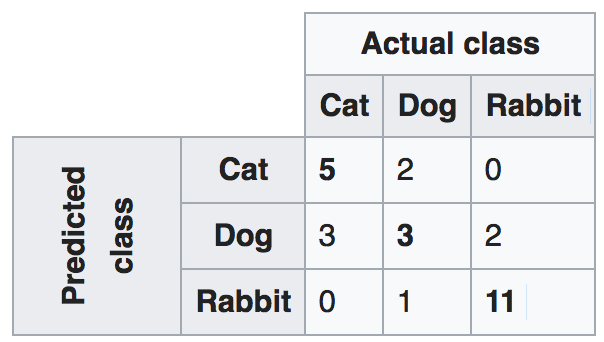

Для того, чтобы облегчить вам задачу, ниже реализована функция `visualize_confusion_matrix` которая визуализирует такую матрицу.  
Вам осталось реализовать функцию `build_confusion_matrix`, которая ее вычислит.

Результатом должна быть матрица 10x10.

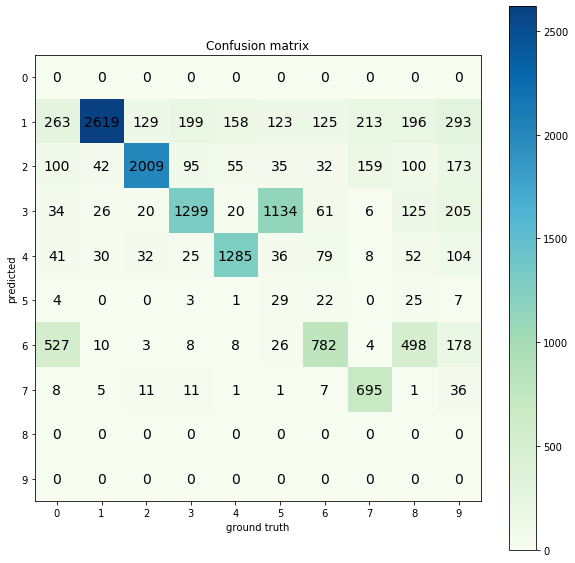

In [85]:
def visualize_confusion_matrix(confusion_matrix):
    """
    Visualizes confusion matrix
    
    confusion_matrix: np array of ints, x axis - predicted class, y axis - actual class
                      [i][j] should have the count of samples that were predicted to be class i,
                      but have j in the ground truth
                     
    """
    # Adapted from 
    # https://stackoverflow.com/questions/2897826/confusion-matrix-with-number-of-classified-misclassified-instances-on-it-python
    assert confusion_matrix.shape[0] == confusion_matrix.shape[1]
    size = confusion_matrix.shape[0]
    fig = plt.figure(figsize=(10,10))
    plt.title("Confusion matrix")
    plt.ylabel("predicted")
    plt.xlabel("ground truth")
    res = plt.imshow(confusion_matrix, cmap='GnBu', interpolation='nearest')
    cb = fig.colorbar(res)
    plt.xticks(np.arange(size))
    plt.yticks(np.arange(size))
    for i, row in enumerate(confusion_matrix):
        for j, count in enumerate(row):
            plt.text(j, i, count, fontsize=14, horizontalalignment='center', verticalalignment='center')
    
def build_confusion_matrix(predictions, ground_truth):
    """
    Builds confusion matrix from predictions and ground truth

    predictions: np array of ints, model predictions for all validation samples
    ground_truth: np array of ints, ground truth for all validation samples
    
    Returns:
    np array of ints, (10,10), counts of samples for predicted/ground_truth classes
    """
    
    confusion_matrix = np.zeros((10,10), np.int)
    
    for i in range(len(predictions)):
        confusion_matrix[predictions[i], gt[i]] += 1
        
    return confusion_matrix

confusion_matrix = build_confusion_matrix(predictions, gt)
visualize_confusion_matrix(confusion_matrix)

In [93]:
np.unique(gt), np.bincount(gt)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 array([ 977, 2732, 2204, 1640, 1528, 1384, 1108, 1085,  997,  996]))

In [94]:
np.unique(predictions), np.bincount(predictions)

(array([1, 2, 3, 4, 5, 6, 7]),
 array([   0, 4318, 2800, 2930, 1692,   91, 2044,  776]))

Наконец, посмотрим на изображения, соответствующие некоторым элементам этой матрицы.

Как и раньше, вам дана функция `visualize_images`, которой нужно воспрользоваться при реализации функции `visualize_predicted_actual`. Эта функция должна вывести несколько примеров, соответствующих заданному элементу матрицы.

Визуализируйте наиболее частые ошибки и попробуйте понять, почему модель их совершает.

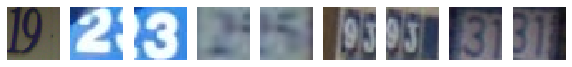

In [98]:
visualize_images([1, 2, 3, 4, 5, 6, 7, 8, 9], data_train_images)

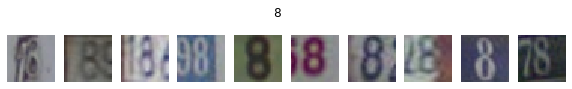

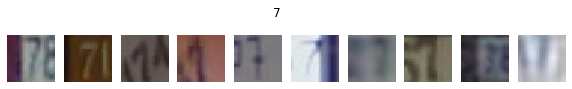

In [168]:
data_train_images = dset.SVHN('./data/', split='train')

def visualize_images(indices, data, title='', max_num=10):
    """
    Visualizes several images from the dataset
 
    indices: array of indices to visualize
    data: torch Dataset with the images
    title: string, title of the plot
    max_num: int, max number of images to display
    """
    to_show = min(len(indices), max_num)
    fig = plt.figure(figsize=(10,1.5))
    fig.suptitle(title)
    for i, index in enumerate(indices[:to_show]):
        plt.subplot(1,to_show, i+1)
        plt.axis('off')
        sample = data[index][0]
        plt.imshow(sample)
        
def visualize_predicted_actual(predicted_class, gt_class, predictions, groud_truth, val_indices, data):
    """
    Visualizes images of a ground truth class which were predicted as the other class 
    
    predicted: int 0-9, index of the predicted class
    gt_class: int 0-9, index of the ground truth class
    predictions: np array of ints, model predictions for all validation samples
    ground_truth: np array of ints, ground truth for all validation samples
    val_indices: np array of ints, indices of validation samples
    """
    y_pred = np.array(predictions)
    y_true = np.array(groud_truth)
    indexes = np.array(val_indices)
    indexes = indexes[(y_true==gt_class) & (y_pred==predicted_class)]
    
    visualize_images(indexes[: 10], data, title=str(gt_class))

    # TODO: Implement visualization using visualize_images above
    # predictions and ground_truth are provided for validation set only, defined by val_indices
    # Hint: numpy index arrays might be helpful
    # https://docs.scipy.org/doc/numpy/user/basics.indexing.html#index-arrays
    # Please make the title meaningful!
    
    

visualize_predicted_actual(6, 8, predictions, gt, np.array(val_indices), data_train_images)
visualize_predicted_actual(1, 7, predictions, gt, np.array(val_indices), data_train_images)

In [166]:
data_train[56201][1], int(nn_model(data_train[56201][0].reshape(1, -1)).argmax())

(8, 6)

In [165]:
data_train[55740][1], int(nn_model(data_train[55740][0].reshape(1, -1)).argmax())

(7, 1)

# Переходим к свободным упражнениям!

Натренируйте модель как можно лучше - экспериментируйте сами!
Что следует обязательно попробовать:
- перебор гиперпараметров с помощью валидационной выборки
- другие оптимизаторы вместо SGD
- изменение количества слоев и их размеров
- наличие Batch Normalization

Но ограничиваться этим не стоит!

Точность на тестовой выборке должна быть доведена до **80%**

In [172]:
# Learning rate annealing
# Reduce your learning rate 2x every 2 epochs
# Hint: look up learning rate schedulers in PyTorch. You might need to extend train_model function a little bit too!

nn_model = nn.Sequential(
            Flattener(),
            nn.Linear(3*32*32, 100),
            nn.BatchNorm1d(100),    
            nn.ReLU(inplace=True),
            nn.Linear(100, 100),
            nn.BatchNorm1d(100),
            nn.ReLU(inplace=True),
            nn.Linear(100, 10), 
         )

nn_model.type(torch.FloatTensor)

optimizer = optim.Adam(nn_model.parameters(), lr=1e-2)
scheduler = MultiStepLR(optimizer, milestones=[5, 10, 15, 20, 25, 30, 35], gamma=0.5, last_epoch=-1)
loss = nn.CrossEntropyLoss().type(torch.FloatTensor)

loss_history, train_history, val_history = train_model_scheduler(nn_model, train_loader, val_loader, loss, optimizer, scheduler, 40)

epoch: 0, lr: [0.01]
Average loss: 1.363781, Train accuracy: 0.547435, Val accuracy: 0.693741
epoch: 1, lr: [0.01]
Average loss: 0.967200, Train accuracy: 0.696891, Val accuracy: 0.723500
epoch: 2, lr: [0.01]
Average loss: 0.855044, Train accuracy: 0.734805, Val accuracy: 0.760631
epoch: 3, lr: [0.01]
Average loss: 0.787115, Train accuracy: 0.754035, Val accuracy: 0.775032
epoch: 4, lr: [0.01]
Average loss: 0.740886, Train accuracy: 0.772958, Val accuracy: 0.778582
epoch: 5, lr: [0.01]
Average loss: 0.716594, Train accuracy: 0.778367, Val accuracy: 0.798444
epoch: 6, lr: [0.005]
Average loss: 0.631164, Train accuracy: 0.806641, Val accuracy: 0.808545
epoch: 7, lr: [0.005]
Average loss: 0.613194, Train accuracy: 0.810941, Val accuracy: 0.811890
epoch: 8, lr: [0.005]
Average loss: 0.603294, Train accuracy: 0.814080, Val accuracy: 0.822060
epoch: 9, lr: [0.005]
Average loss: 0.590274, Train accuracy: 0.817425, Val accuracy: 0.818852
epoch: 10, lr: [0.005]
Average loss: 0.580339, Train acc

In [173]:
# Как всегда, в конце проверяем на test set
test_loader = torch.utils.data.DataLoader(data_test, batch_size=batch_size)
test_accuracy = compute_accuracy(nn_model, test_loader)
print("Test accuracy: %2.4f" % test_accuracy)

Test accuracy: 0.8161


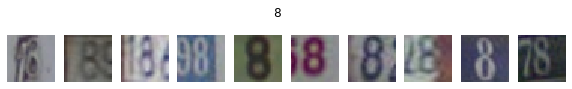

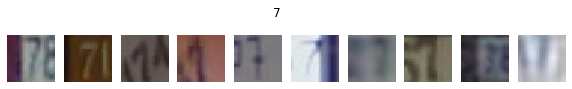

In [174]:
visualize_predicted_actual(6, 8, predictions, gt, np.array(val_indices), data_train_images)
visualize_predicted_actual(1, 7, predictions, gt, np.array(val_indices), data_train_images)